# VAE MNIST example
## Pre-requirements
* python 3
* torch
* torchvision
* tqdm
* matplotlib

## Originality
https://github.com/pytorch/examples/tree/master/vae

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
batch_size = 36
epochs = 30
num_z = 1024

torch.manual_seed(1)
torch.cuda.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch is using', device)

PyTorch is using cuda


In [3]:
# Download COCO dataset if not available
import requests
from tqdm.notebook import tqdm
import zipfile
import os.path

def download(url):
    name = url.split('/')[-1]
    print(f'Downloading file from {url} to {name}')
    
    with open(name, 'wb') as f:
        res = requests.get(url, stream=True)
        length = res.headers.get('Content-Length')
        
        if length is None:
            f.write(res.content)
        else:
            for data in tqdm(res.iter_content(chunk_size=4096), total=int(int(length) / 4096)):
                f.write(data)
        
    return name
                
if not os.path.isfile('test2017.zip'):
    download('http://images.cocodataset.org/zips/test2017.zip')
    
if not os.path.isdir('test'):
    os.makedirs('test')
    
    with zipfile.ZipFile('test2017.zip', 'r') as f:
        f.extractall('test')
    
if not os.path.isfile('val2017.zip'):
    name = download('http://images.cocodataset.org/zips/val2017.zip')
    
if not os.path.isdir('val'):
    os.makedirs('val')
    
    with zipfile.ZipFile('val2017.zip', 'r') as f:
        f.extractall('val')

transform = transforms.Compose([
    transforms.Resize(size=(120, 160)),
    transforms.ToTensor(),    
])

train_dataset = datasets.ImageFolder(root='test', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=4)
test_dataset = datasets.ImageFolder(root='val', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, prefetch_factor=4)

In [4]:
# Define VAE class, optimizer, loss_function, train and test

import numpy as np

layers = [120 * 160, int(120 * 160 / 2), int(120 * 160 / 4), int(120 * 160 / 8)]

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        encoders = []
        decoders = []
        
        for i in range(len(layers) - 1):
            encoders.append(nn.Linear(layers[i], layers[i + 1]))
            encoders.append(nn.ReLU())
            
        for i in range(len(layers) - 1, 0, - 1):
            decoders.append(nn.ReLU())
            decoders.append(nn.Linear(layers[i], layers[i - 1]))
        
        self.encoder = nn.Sequential(*encoders)
        
        self.z_mu = nn.Linear(layers[-1], num_z)
        self.z_logvar = nn.Linear(layers[-1], num_z)
        
        self.decoder = nn.Sequential(
            nn.Linear(num_z, layers[-1]),
            *decoders
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.z_mu(h), self.z_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def decode(self, z):
        x_bar = self.decoder(z)
        return torch.sigmoid(x_bar)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, layers[0]))
        z = self.reparameterize(mu, logvar)
        recon_batch = self.decode(z)
        recon_batch = recon_batch.view(*x.shape)
        
        return recon_batch, mu, logvar


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, layers[0]), x.view(-1, layers[0]), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [5]:
from tqdm.notebook import tqdm

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        train_loss += loss.item() / len(train_loader.dataset)
        loss.backward()
        optimizer.step()
        
    return train_loss


def reconstruct():
    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)

            n = min(data.shape[0], 8)
            samples = np.array(data[:n].cpu())
            recons = np.array(recon_batch[:n].cpu())
            
            break

    return samples, recons


def test(epoch):
    model.eval()
    
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item() / len(test_loader.dataset)
    
    return test_loss

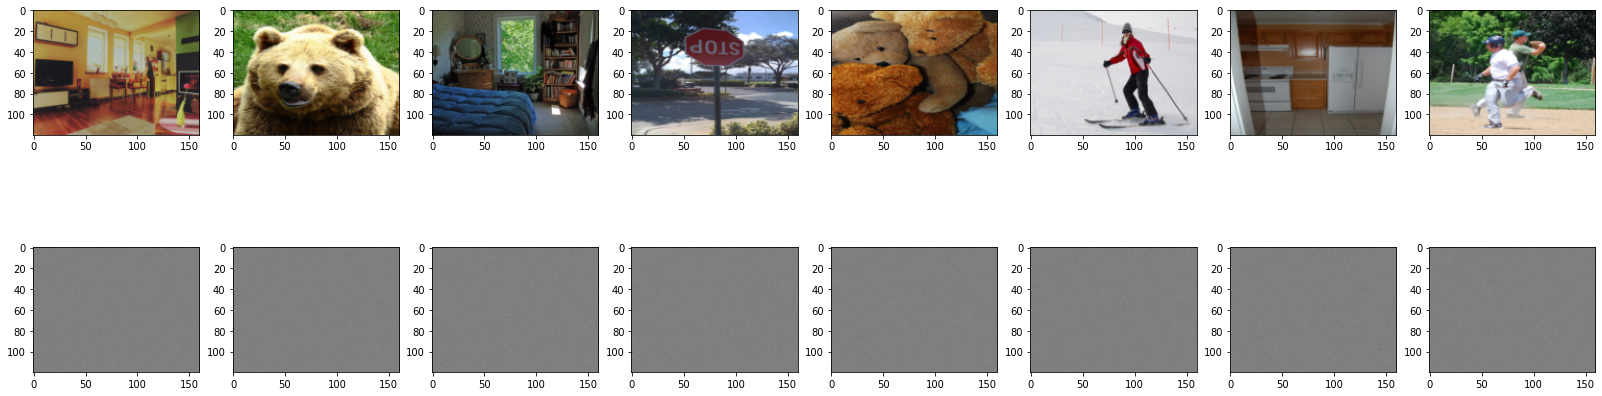

  0%|          | 0/1130 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import time

def to_rgb(sample):
    r = sample[0]
    g = sample[1]
    b = sample[2]
    rgb = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)
    return rgb

# Learn
last_loss = torch.finfo(torch.float32).max
total_time = 0
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    samples, recons = reconstruct()
    
    n = len(samples)
    plt.figure(figsize=(28, 8))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(to_rgb(samples[i]))
        
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(to_rgb(recons[i]))
        
    plt.show()
    
    start_time = time.time()
    loss = train(epoch)
    end_time = time.time()
    
    train_losses.append(loss)
    
    dt = end_time - start_time
    total_time += dt
    
    loss = test(epoch)
    test_losses.append(loss)
    
    print(f'Epoch {epoch} / {epochs}: {loss:.2f} in {dt:.2f} secs', '*' if loss < last_loss else '')

print('Train loss:', train_losses)
print('Test loss:', test_losses)
print(f'Average {total_time / epochs:.2f} secs per epoch consumed')
print(f'Total {total_time:.2f} secs consumed')
